 # Developing a system for categorizing movie reviews 

'Junky Union', a community for classic movie lovers, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to detect negative reviews automatically.

## Contents <a id='back'></a>

* [Intro](#intro)
* [Stage 1. Data loading and preprocessing](#data_review)
    * [1.1 Data exploration](#explore_data)
* [Stage 2. Data division](#data_division)
* [Stage 3. Model analysis](#model_analysis)
    * [3.1 Decision tree](#decision_tree)
    * [3.2 Random forest](#random_forest)
    * [3.3 Logistic regression](#logistic_regression)
    * [3.4 Model comparison](#model_comparison)
* [Stage 4. Model quality](#model_quality)
    * [4.1 Decision tree](#decision_tree_quality)
    * [4.2 Random forest](#random_forest_quality)
    * [4.3 Logistic regression](#logistic_regression_quality)
* [Stage 5. Sanity test](#sanity_test)
* [Conclusion](#conclusion)

## Introduction <a id='intro'></a>

We will use a dataset of IMDb (Internet Movie Database) with polarity legends to build a model to classify positive and negative reviews. This must reach an F1 value of at least 0.85.

## Stage 1. Data loading and preprocessing <a id='data_review'></a>

In [42]:
# Loading all libraries
import math
import random

import numpy as np
import pandas as pd

from nltk.corpus import stopwords as nltk_stopwords
import spacy
import re

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

import sklearn.metrics as metrics
from sklearn.dummy import DummyClassifier

In [38]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'  

# this helps having graphics of better quality
%config InlineBackend.figure_format = 'retina'

sns.set_style('darkgrid') 

In [39]:
# this is for using
tqdm.pandas()

In [8]:
# Load the data files into DataFrame
df = pd.read_csv('https://code.s3.yandex.net/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [9]:
df.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


### 1.1 Data exploration <a id='explore_data'></a>

In [10]:
# printing the general/summary information about the df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

'average_rating' and 'votes' are the only columns with null values. We can just drop those lines:

In [15]:
# remover NAN
df.dropna(inplace=True)
df.reset_index(inplace=True, drop=True)

The dataset contains the following relevant fields:
- `review` — the text of the review
- `pos` — the target, '0' for negative and '1' for positive
- `ds_part` — training'/'test' for the training/testing part of the data set

In [16]:
df.duplicated().sum()

0

In [40]:
# calling the describe method with round(3)
df.describe().round(3)

,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47329.000,47329.000,47329.000,47329.0,47329.000,47329.000,47329.000
mean,1989.631,0.002,5.998,25562.917,5.484,0.499,6279.827
std,19.601,0.042,1.494,83670.039,3.473,0.500,3605.724
min,1894.000,0.000,1.400,9.0,1.000,0.000,0.000
25%,1982.000,0.000,5.100,827.0,2.000,0.000,3162.000
50%,1998.000,0.000,6.300,3197.0,4.000,0.000,6300.000
75%,2004.000,0.000,7.100,13974.0,9.000,1.000,9412.000
max,2010.000,1.000,9.700,1739448.0,10.000,1.000,12499.000


It's weird but the first movie was in 1894 while the last is in 2010. Mean 'average_rating' is ~6

Let's look at the number of movies and reviews over the years:

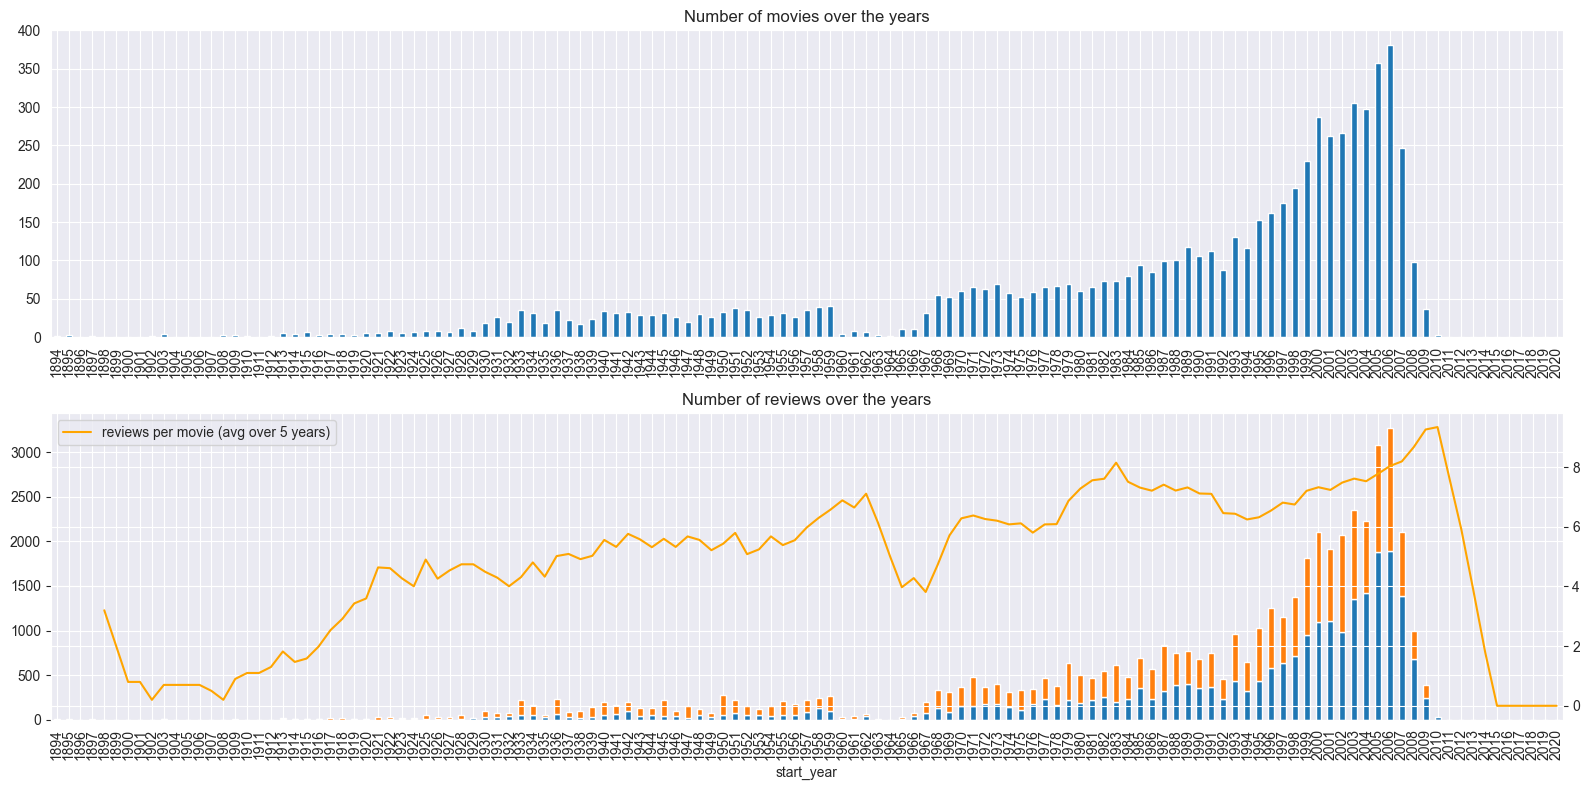

In [17]:
# set the number of rows and columns, as well as the size of subplots
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

# Axis 0 - Graph for the first row
ax = axs[0]

# get the count of unique values for each year and plot a bar chart.
dft1 = df[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of movies over the years')

# Axis 0 - Graph for the second row
ax = axs[1]

# grouping by year and pos, then get the number of positive and negative reviews in each year.
dft2 = df.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

# plot a bar graph
dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

# get the number of reviews per year
dft2 = df['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

# get the number of reviews a movie receive each year
# plot a line graph for the number of reviews per movie every five years
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

# set a legend that indicates the content of the second graph
lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')
ax.set_title('Number of reviews over the years')

fig.tight_layout()

So, the number of movies increased over the period 1930 - 2006. After that, there was a drop. Last year recorded is 2010. About the number of reviews per year, the trend is similar (in shape) to the graphic above. We can also say that the proportion of positive reviews (blue ones) is increasing over the years.

Let's look at the distribution of the number of reviews per movie with the exact count and KDE (Kernel Density Estimation), just to know how it can differ from the exact count.

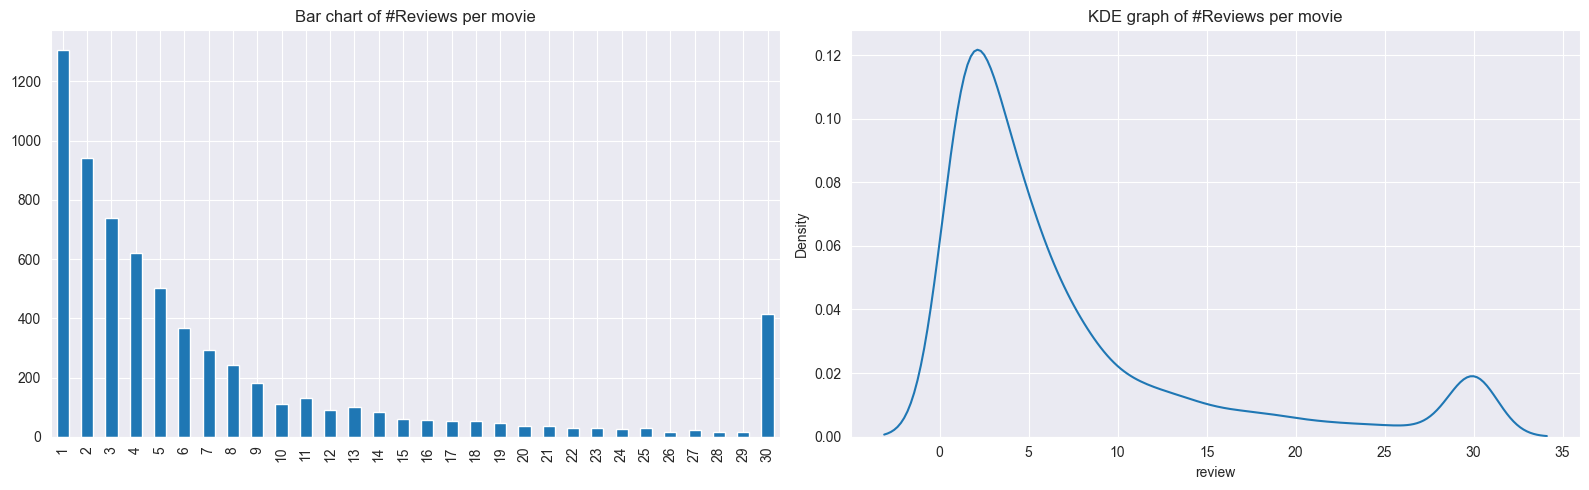

In [18]:
# set the number of rows and columns, as well as the size of subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# Axis 0 - Graph 1
ax = axs[0]

# grouping by the code of each movie 'tconst' and get the number of reviews of each one
# get the unique value count of the number of reviews, how many movies received a given number of reviews
# plot a bar graph
dft = df.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar chart of #Reviews per movie')

# Axis 1 - Graph 2
ax = axs[1]

# grouping by the code of each movie 'tconst' and obtain the number of reviews of each one
# plot a density distribution graph
dft = df.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE graph of #Reviews per movie')

fig.tight_layout()

So, the graphic on the left say that more than 1200 movies got just one review, less than 1000 movies got only 2 reviews and so on. For the density distribution graph there is a similar pattern, with the highest frequency density of around 0.12 being observed between 0 to 5 reviews and then a weird peak occurring around 30 reviews.

Let's quickly analyze the number of positive and negative reviews and establish if there is a class imbalance.

In [19]:
df['pos'].value_counts()

0    23715
1    23614
Name: pos, dtype: int64

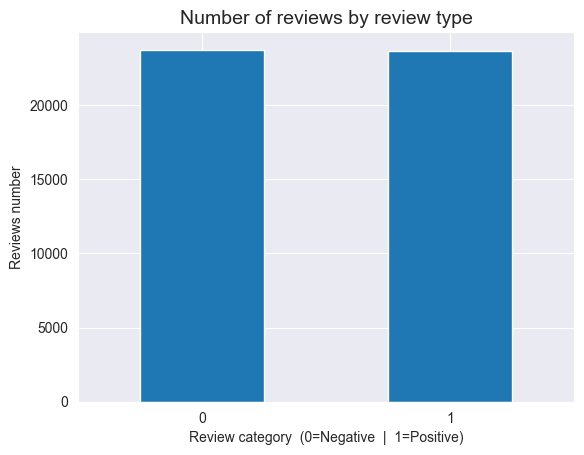

0    23715
1    23614
Name: pos, dtype: int64


In [27]:
df['pos'].value_counts().plot(kind='bar', xlabel='Review category  (0=Negative  |  1=Positive)', ylabel='Reviews number',rot= 360)
plt.title('Number of reviews by review type', fontsize=14)
plt.show()
print(df['pos'].value_counts())

It seems no class imbalance occurs. No need to upsample or downsample part of the dataframe.

Let's analyze more in detail if there is a class imbalance looking at the distribution of positive and negative classes in the training and test set.

In [37]:
df_train =  df.query('ds_part == "train"')
df_test =  df.query('ds_part == "test"')
pos_train = df_train['pos'].value_counts(normalize=True)
pos_test = df_test['pos'].value_counts(normalize=True)

print('Training set, ratio of negative to positive reviews:')
print(pos_train)

print()
print('Test set, ratio of negative to positive reviews:')
print(pos_test)

Training set, ratio of negative to positive reviews:
0    0.500588
1    0.499412
Name: pos, dtype: float64

Test set, ratio of negative to positive reviews:
0    0.501551
1    0.498449
Name: pos, dtype: float64


In this case too, everything is well balanced. This is good for training!

Let's now analyze the distribution of films by ratings in each data set:

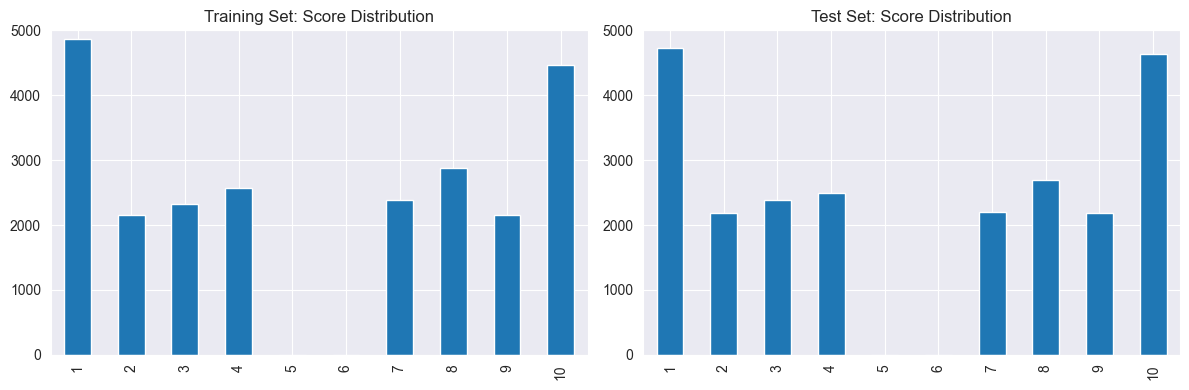

In [20]:
# set the number of rows and columns, as well as the size of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# first graph
ax = axs[0]

# filtering the dataset by the training set and obtain unique values by 'rating'
# plot a bar graph
dft = df.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('Training Set: Score Distribution')

# second graph
ax = axs[1]

# filtering the dataset by the test set and obtain unique values by 'rating'
# plot a bar graph
dft = df.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('Test Set: Score Distribution')

fig.tight_layout()

Distribution of negative and positive reviews over the years for two parts of the data set:

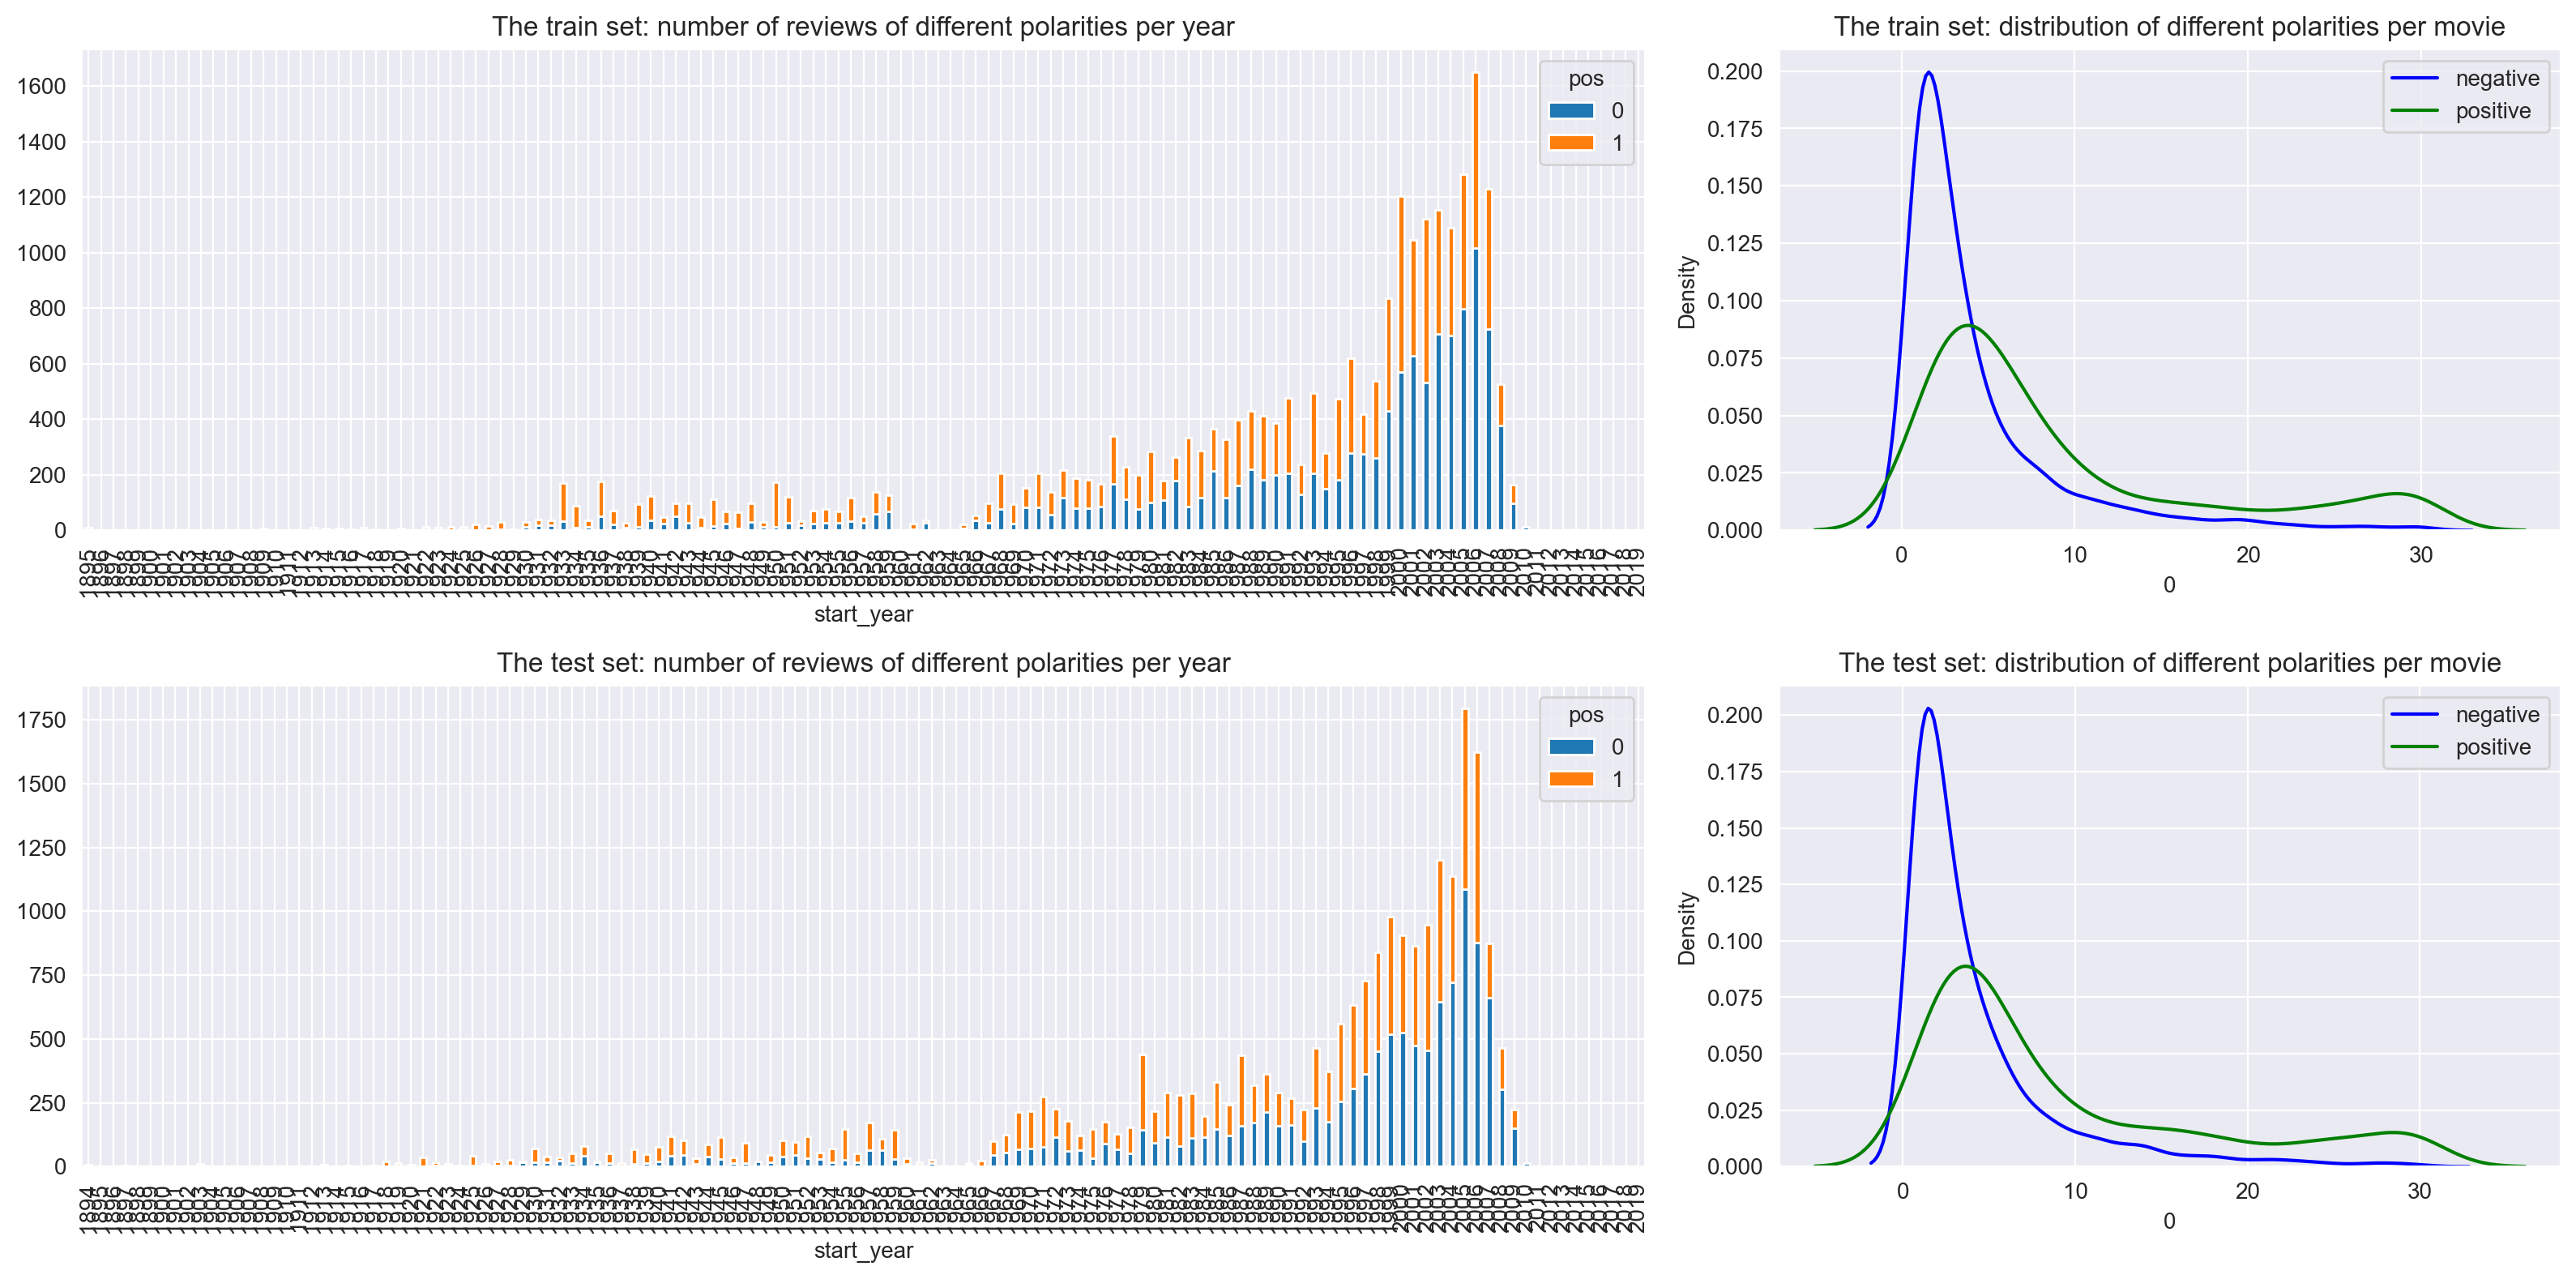

In [41]:
# set the number of rows and columns, as well as the size of subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

# Graph 0,0 axis - 1st row, 1st column
ax = axs[0][0]

# filtering the dataset with training data, group by 'start_year' and 'pos'
# converting the index to an integer type
# plot a bar chart of the number of reviews by year and review polarity 'pos'
dft = df.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Train set: number of reviews of different polarities per year')

# Graph 0,0 axis - 1st row, 2nd column
ax = axs[0][1]

# filtering the dataset with training data, group by identifier 'tconst' and 'pos'
# get the number of positive and negative reviews for each movie
# plot a distribution graph of densities by positive and negative reviews
dft = df.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', ax=ax)
ax.legend()
ax.set_title('Train set: distribution of different polarities per movie')

# Graph 1,0 axis - 2nd row, 1st column
ax = axs[1][0]

# filtering the dataset with test data, group by 'start_year' and 'pos'
# converting the index to an integer type
# plot a bar chart of the number of reviews by year and review polarity 'pos'
dft = df.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Test set: number of reviews of different polarities per year')

# Graph 1,1 axis - 2nd row, 2nd column
ax = axs[1][1]

# filtering the dataset with test data, group by identifier 'tconst' and 'pos'
# get the number of positive and negative reviews for each movie
# plot a distribution graph of densities by positive and negative reviews
dft = df.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', ax=ax)
ax.legend()
ax.set_title('Test set: distribution of different polarities per movie')

fig.tight_layout()

So generally speaking, there is an increase in the number of reviews and there is also an increase of negative reviews. About the polarity, the two graphs are pretty similar. Those films that got between 0 and 5 reviews, show a bigger proportion of negative reviews, while for movies that got more reviews have more positive reviews than negative.

##  Evaluation procedure

In order to evaluate the performance of machine learning models for text, we will use the F1 value as a measurement metric, selecting the model that reaches an F1 of at least 0.85. We will build the 'evaluate_model' function that will allow us to compose an evaluation routine that can be used for all the models in this project.

In [ ]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    '''
     this function returns the values for accuracy, average precision, F1 score, and ROC-AUC.
     It also returns ROC-AUC, F1 and PRC (precision-recall curve) curve plots
    
     :model: model pretrained and with hyperparameter tuning
     :train_features: training features
     :train_target_ test features
     :test_features: training target
     :test_target: test target
    
    '''    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any punctuations marks, digits etc.

In [ ]:
def clear_text(text):
    pattern = r"[^a-zA-Zñ']"
    text = re.sub(pattern, " ", text).lower()
    stop_words = set(nltk_stopwords.words("english"))
    list_words = text.split()
    filtered_words = [word for word in list_words if word not in stop_words]
    text = " ".join(filtered_words) 

    return text

In [ ]:
df['review_norm'] = df.review.apply(clear_text)

In [ ]:
df['review_norm']

In [ ]:
# corpus = df['review']

# def clear_text(text):
#     text = re.sub(r'[^a-zA-z\']', ' ', text)
#     text = text.split()
#     text = " ".join(text)
#     return text

# nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# def lemmatize(text):
#     doc = nlp(text.lower())
#     lemmas = []
    
#     for token in doc:
#         lemmas.append(token.lemma_)
        
#     return ' '.join(lemmas)

# new_corpus = []

# for i in range(0, len(corpus)-1):
#     review = corpus[i]
#     new_text = lemmatize(clear_text(review))
#     new_corpus.append(new_text)

## Train / Test split

Fortunately, the entire data set is already divided into training/test parts; 'ds_part' is the related column.

In [ ]:
df_train = df.query('ds_part == "train"').copy()
df_test = df.query('ds_part == "test"').copy()

train_target = df_train['pos']
test_target = df_test['pos']

print(df_train.shape)
print(df_test.shape)

In [ ]:
X_train, X_test, Y_train, Y_test = df_train.drop(['pos'], axis=1), df_test.drop(['pos'], axis=1), train_target, test_target

## Working with models

### Model 0 - Constant

In [ ]:
model_dummy = DummyClassifier(strategy='constant', constant=1)
model_dummy.fit(X_train, Y_train)
evaluate_model(model_dummy, X_train, Y_train, X_test, Y_test)

### Modelo 1 - NLTK, TF-IDF y LR

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
corpus = df['review']

def clear_text(text):
    text = re.sub(r'[^a-zA-z\']', ' ', text)
    text = text.split()
    text = " ".join(text)
    return text

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def lemmatize(text):
    doc = nlp(text)
    lemmas = []
    
    for token in doc:
        lemmas.append(token.lemma_)

    return ' '.join(lemmas)

new_corpus = []

for i in range(0, len(corpus)-1):
    review = corpus[i]
    new_text = lemmatize(clear_text(review))
    new_corpus.append(new_text)

In [ ]:
df['review_lemm'] = new_corpus

In [ ]:
# creating a counter and define stopwords
stop_words = nltk_stopwords.words('english')
tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words)

